In [1]:
import sympy as sp
sp.init_printing(use_latex ='mathjax')

import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import os
import pandas as pd
import scipy as sc
from sklearn.linear_model import LinearRegression
import cython

In [2]:
#Define column names and read csv file

base1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file1 = 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv'

base2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file2 = 'Array01.00r0.5p3Device1.2RandomNodeCoupling500/Data.csv'

path1 = os.path.join(base1, file1)
path2 = os.path.join(base2, file2)

colnames= ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df1 = pd.read_csv(path1, names = colnames)
df2 = pd.read_csv(path2, names = colnames)

In [3]:
#Fit linear part of phase lag to subtract from graph

#Define normalized data for fitting
maxR1 = df1['R'].max()
df1['Rnorm'] = (df1.R) / (maxR1)
df1['Fnorm'] = df1.F / 10**6
df1['Rnorm2']= ((df1.R)/maxR1)**2

df2['Rnorm'] = (df2.R) / (maxR1)
df2['Fnorm'] = df2.F / 10**6
df2['Rnorm2']= ((df2.R)/maxR1)**2

#Definte linear portion of less than 15MHz for fit
mk = df1.Fnorm < 15

x1 = df1[['Fnorm']][mk]
y1 = df1.theta[mk]

x2 = df2[['Fnorm']][mk]
y2 = df2.theta[mk]

#Perform linear fit
model1 = LinearRegression().fit(x1,y1)
r_sq1 = model1.score(x1,y1)

model2 = LinearRegression().fit(x2,y2)
r_sq2 = model2.score(x2,y2)

df1['thetaLin'] = df1.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df1['radLin'] = df1.thetaLin * np.pi / 180
df1['wrap'] = np.unwrap(df1.radLin)

df2['thetaLin'] = df2.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df2['radLin'] = df2.thetaLin * np.pi / 180
df2['wrap'] = np.unwrap(df2.radLin)

freq1 = df1.F.values
amps1 = df1.Rnorm.values
phases1 = df1.wrap.values

freq2 = df2.F.values
amps2 = df2.Rnorm.values
phases2 = df2.wrap.values

In [17]:
#Define all variables

#individual springs that correspond to individual masses
k1,k2 = (0.0063,0.0016)
k3 = sp.symbols('k_3')

#springs that connect two masses
#k12, k23, k13 = (6*10**-5,0.8*10**-5,0.8*10**-5)
k12 = (6*10**-5)
k13, k23 = sp.symbols('k_13, k_23')

#damping coefficients and forc
g1, g2, g3 = (5*10**4,5*10**4,5*10**4)
 
#masses
m1, m2, m3 = (2.7*10**-17,6.8*10**-18, 2.7*10**-17)
#m1, m2 = (2.7*10**-17,6.8*10**-18)
#m3 = sp.symbols('m_3')

#Driving force amplitude
F = (2.5*10**-5)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

#Solve for the eigenefrequencies of steady state solutions

steadyState = sp.Matrix([[(k1/m1) + (k12/m1)+ (k13/m1), -k12/m1, -k13/m1], [-(k12/
  m2), (k2/m2) + (k12/m2) + (k23/m2), -(k23/m2)], [-k13/m3, -(k23/
  m3), (k3/m3) + (k23/m3)+ (k13/m3)]])

(e1,mult1,A), (e2,mult2,B), (e3,mult3,C)= steadyState.eigenvects()

#Neglect imaginary part because it is very small
w1, w2, w3 = (sp.sqrt(sp.re(e1)-((g1/m1)**2)/4), sp.sqrt(sp.re(e2)-((g2/m2)**2)/4), sp.sqrt(sp.re(e3)-((g3/m3)**2)/4))

In [18]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1)+(k13/m1), -k12/m1, -(k13/m1)], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2) + (k23/m2), -k23/m2], [-(k13/m3), -k23/m3, -wd**2 + 
  1j*wd*g3 + (k3/m3) + (k23/m3)+ (k13/m3)]])


#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1, -(k13/m1)], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2) + (k23/m2), -k23/m2], [0, -k23/m3, -wd**2 + 
  1j*wd*g3 + (k3/m3) + (k23/m3)+ (k13/m3)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1)+(k13/m1), F/m1, -(k13/m1)], [-k12/m2, 0, -k23/m2], [-(k13/m3),0, -wd**2 + 
  1j*wd*g3 + (k3/m3) + (k23/m3)+ (k13/m3)]])

driven_m3 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1)+(k13/m1), -k12/m1, F/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2) + (k23/m2),0], [-(k13/m3), -k23/m3,0]])

#Apply Cramer's Rule
Cr1, Cr2, Cr3 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det(),driven_m3.det()/driven.det(),)

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)
delta3 = sp.arg(Cr3)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)
wrap3 = (delta3)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)
amp3 = sp.re(Cr3)/sp.cos(delta3)

In [19]:
def func(wd, k3, k13, k23):
    return sp.lambdify((wd, k3, k13, k23),amp1)

amp1_f = sp.lambdify((wd, k3, k13, k23),amp1)

def func2(wd, k3, k13, k23):
    return sp.lambdify((wd, k3, k13, k23),wrap1)

phase1_f = sp.lambdify((wd, k3, k13, k23),wrap1)

In [20]:
popt1, pcov1 = sc.optimize.curve_fit(func(wd, k3, k13, k23), freq1, amps1, p0 = (0.0063, 1*10**-5,6*10**-5), bounds=(0, [np.inf, np.inf, np.inf]))

popt2, pcov2 = sc.optimize.curve_fit(func2(wd, k3, k13, k23), freq1, phases1+2*np.pi, p0 = (0.0063, 1*10**-5,6*10**-5), bounds=(0, [np.inf, np.inf, np.inf]))

In [21]:
print ('Amp k13, k23=', popt1, 'Phase k13, k23=', popt2)

Amp k13, k23= [6.23177597e-03 1.79891776e-05 7.74689030e-02] Phase k13, k23= [6.22922708e-03 4.67793000e-05 7.48112995e-05]


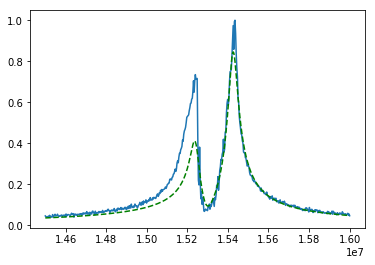

In [22]:
plt.plot(freq1,amps1)
plt.plot(freq1, amp1_f(freq1, *popt1),'g--')

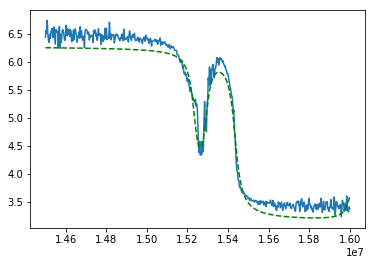

In [23]:
plt.plot(freq1,phases1+2*np.pi)
plt.plot(freq1, phase1_f(freq1, *popt2),'g--')

In [24]:
def func3(wd, k3, k13, k23):
    return sp.lambdify((wd, k3, k13, k23),amp2)

amp2_f = sp.lambdify((wd, k3, k13, k23),amp2)

def func4(wd, k3, k13, k23):
    return sp.lambdify((wd, k3, k13, k23),wrap2)

phase2_f = sp.lambdify((wd, k3, k13, k23),wrap2)

In [26]:
popt3, pcov3 = sc.optimize.curve_fit(func3(wd, k3, k13, k23), freq2, amps2, p0 = (0.0063, 1*10**-5,6*10**-5), bounds=(0, [np.inf, np.inf, np.inf]))

popt4, pcov4 = sc.optimize.curve_fit(func4(wd, k3, k13, k23), freq2, phases2+2*np.pi, p0 = (0.0063, 1*10**-5,6*10**-5), bounds=(0, [np.inf, np.inf, np.inf]))

print ('Amp k23=', popt3, 'Phase k23=', popt4)

Amp k23= [6.19523703e-03 1.33607624e-05 3.09088311e-02] Phase k23= [6.18885408e-03 7.07033726e-04 1.65145890e-25]


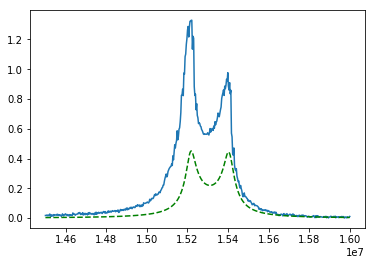

In [27]:
plt.plot(freq2,amps2)
plt.plot(freq2, amp2_f(freq2, *popt3),'g--')

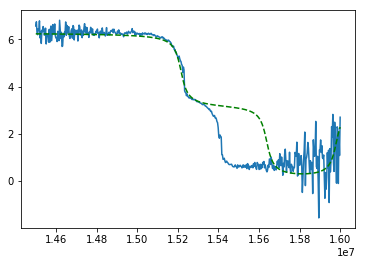

In [28]:
plt.plot(freq2,phases2+2*np.pi)
plt.plot(freq2, phase2_f(freq2, *popt4),'g--')